In [1]:
# Inspired by M. Betancourt https://github.com/betanalpha/jupyter_case_studies/blob/master/principled_bayesian_workflow/principled_bayesian_workflow.ipynb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
#import multiprocessing
import math
import patsy
import arviz as az

import pystan
import stan_utility

## LMMs on chronometric data

## Prior extracted from the stan code

In [3]:
priors_LME = stan_utility.compile_model('LME_prior_only.stan', path="", model_name="LMEprior")

Using cached StanModel


In [4]:
data = pd.read_csv('../EMG_baseline_recoded.csv')

LMEdata = data[np.abs(data.channel) < data.channel.std()*3].copy()
print(LMEdata.head())
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['p_right'] = LMEdata.apply(lambda row: -0.5 if row['p_right'] == 30 else (
        0.5 if row['p_right'] == 70 else 0), axis=1)
LMEdata['EMG'] =  LMEdata.apply(lambda row: 0 if row['EMG'] == "left" else 1, axis=1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["channel","participant",
                   "SAT","EMG","p_right"]]
print(LMEdata.head())


   Unnamed: 0  Unnamed: 0.1  epoch       SAT  p_right direction  rolling_R  \
0           0             0      0  accuracy       50         G   3.106906   
1           1             1      1  accuracy       70         D   3.014578   
2           2             2      2  accuracy       70         D   3.203774   
3           3             3      3  accuracy       30         D   3.198861   
4           4             4      4  accuracy       50         D   3.805115   

   rolling_L     meanL     meanR participant   channel    EMG  
0   3.429526  3.366452  2.844486     S20.csv  2.844486  right  
1   3.473026  3.581556  2.941118     S20.csv  2.941118  right  
2   3.352103  3.667663  3.432137     S20.csv  3.432137  right  
3   3.339906  3.340233  2.336583     S20.csv  2.336583  right  
4   3.410857  3.180437  3.213571     S20.csv  3.213571  right  
    channel  participant  SAT  EMG  p_right
0  2.844486            1    1    1      0.0
1  2.941118            1    1    1      0.5
2  3.432137    

In [5]:
model_name = "baseline_fit_priors"

fixeff_form = "1+SAT+p_right+EMG+SAT:p_right+SAT:EMG+EMG:p_right+SAT:EMG:p_right"#Fixed effects formula
raneff_form = fixeff_form #Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, LMEdata)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, LMEdata)) #RE design matrix
prior_intercept = np.asarray([2.5,1.5])#prior for intercept, mu and sigma
priors_mu = np.repeat(0, 7) #Priors on mu for FE
priors_sigma =  np.repeat(1.5, 7) # priors on sigma for FE
priors_raneff = [0, 1.5] #Priors on RE
prior_sd = [0, 1.5] #priors on residual sigma


LME_data = dict(
    N = len(LMEdata),
    P = fixeff.shape[-1], #number of pop level effects
    J = len(LMEdata.participant.unique()),
    n_u = raneff.shape[-1],
    subj = LMEdata.participant,
    X = fixeff,
    Z_u = raneff,
    y = LMEdata.channel.values,
    p_intercept = prior_intercept, p_sd = prior_sd, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff,
    logT = 0
)



fit = priors_LME.sampling(data=LME_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,thin=2)

baseline_fit_az = az.from_pystan(posterior=fit, posterior_predictive='y_hat', observed_data="y",
                                       coords={'b': fixeff_form.split('+')[1:]}, dims={'beta': ['b']})

In [7]:
import seaborn as sns

In [10]:
pred = fit.extract("y_hat")
pred = np.asarray(fit['y_hat'])
pred = pred.flatten()
sample = np.random.choice(pred, size=1000, replace=False)

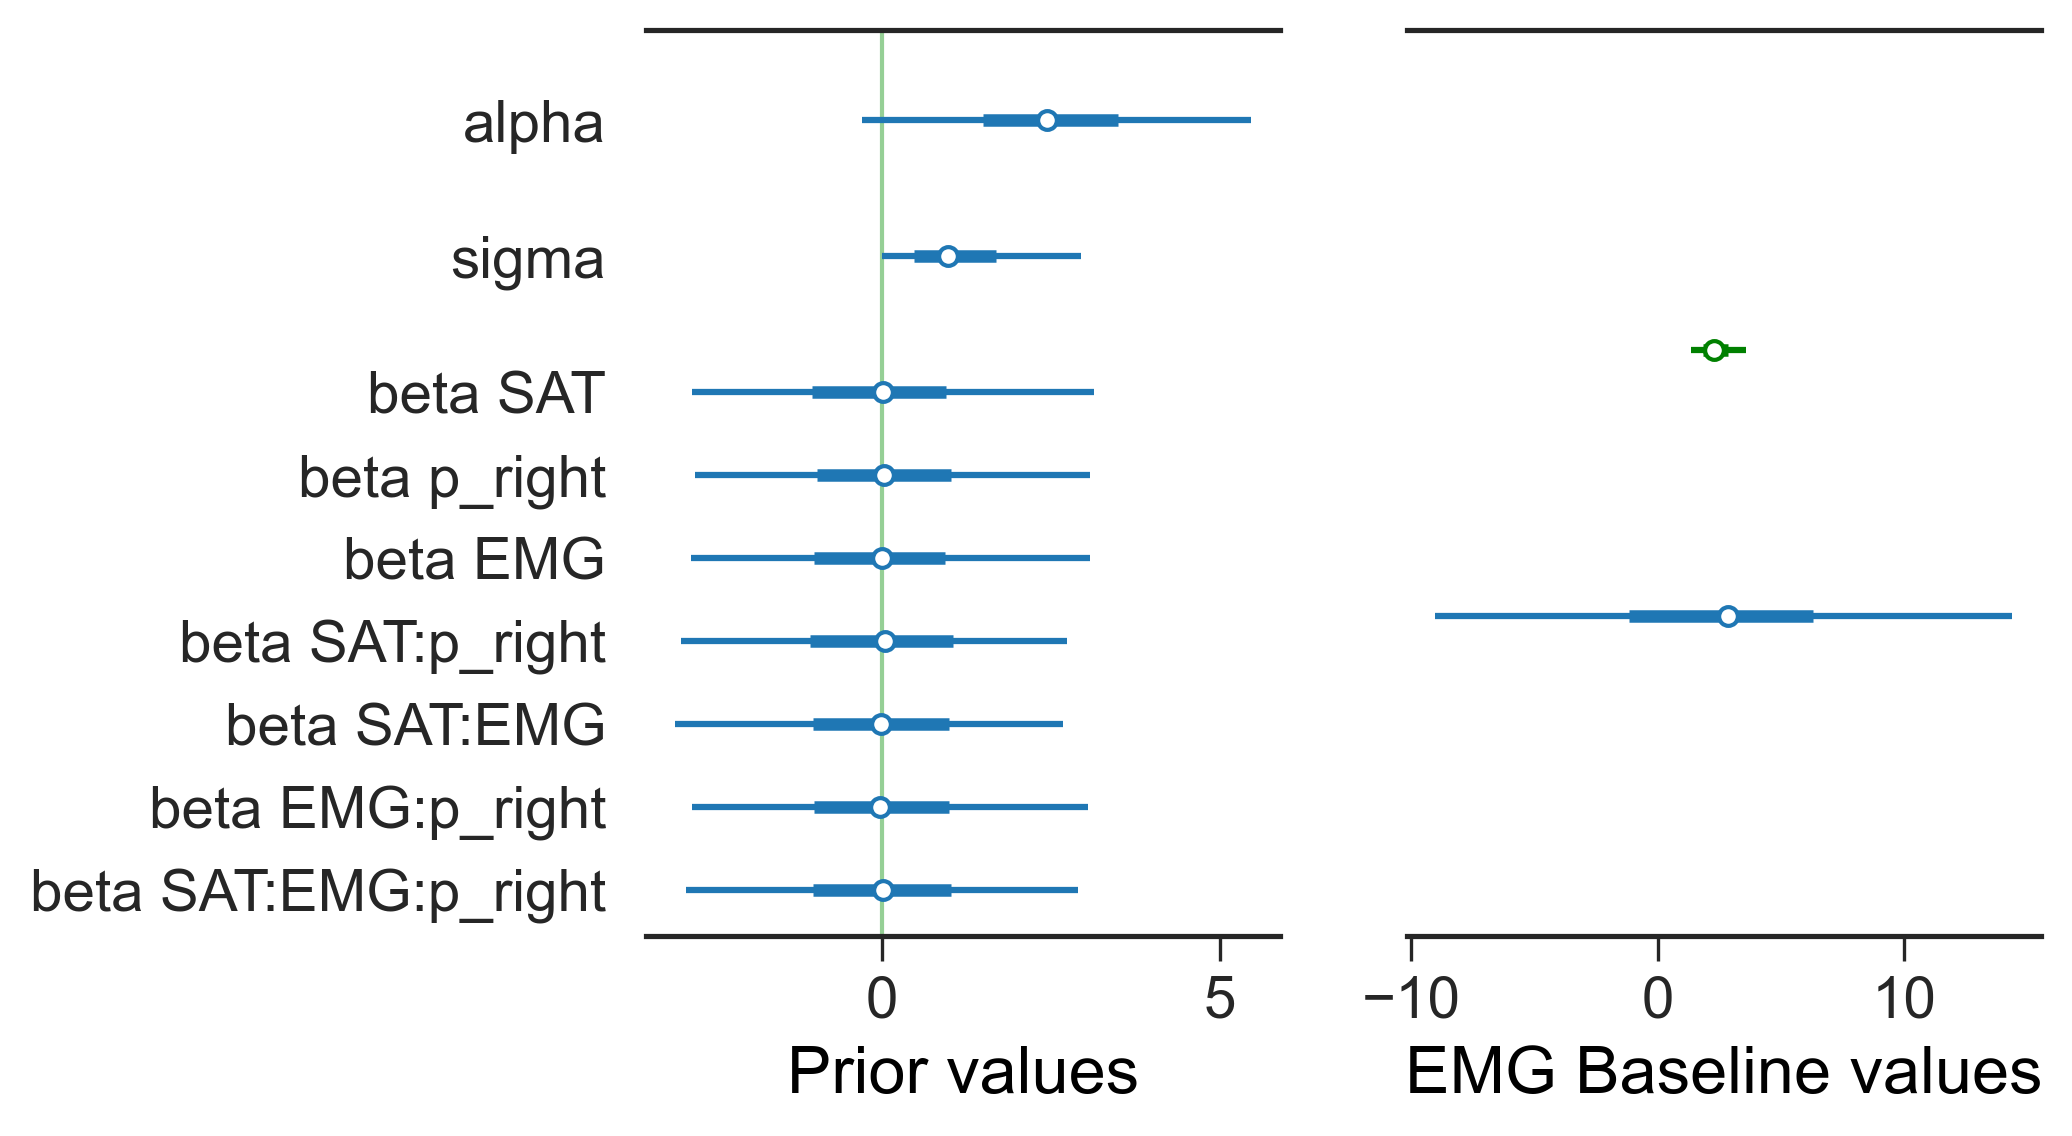

In [15]:
plt.style.use('seaborn-ticks')

font = {'family': 'sans',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }
fig, (ax0,ax1) = plt.subplots(1,2,dpi=300)
#az.plot_forest(LMEdata.channel.values, colors='g', hdi_prob=0.95, ax=ax0)
az.plot_forest(baseline_fit_az, var_names=["alpha",'sigma',"beta"], hdi_prob=0.95, 
                   combined=True, rope=[0,0], ax = ax0)
az.plot_forest([LMEdata.channel.values,sample], colors=['g',sns.color_palette()[0]], model_names=['actual data','data sampled from the priors'],hdi_prob=0.95, ax=ax1)
plt.legend()
ax0.set_xlabel('Prior values',fontdict=font)
ax0.set_title('')
ax1.set_title('')
ax1.set_yticklabels('')
ax1.set_yticklabels('')
ax1.set_xlabel('EMG Baseline values',fontdict=font)
plt.show()
